## Step 1: Importing Libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow_hub as hub

## Step 2: Dataset Inclusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 3: Loading Trained Models

In [ ]:
model_path = "/content/drive/My Drive/Yoga/6_March_vgg16.h5"
model_vgg = load_model(model_path)

In [ ]:
# Load PoseNet model from TensorFlow Hub
posenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

## Step 4: Extracting Pose Keypoints with PoseNet

In [ ]:
# Define function to get pose keypoints from PoseNet
def get_pose_keypoints(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Could not read the image at {image_path}")

    image = tf.image.resize(image, (192, 192))
    image = np.array(image.numpy(), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    image = tf.convert_to_tensor(image, dtype=tf.int32)

    # Run PoseNet model
    outputs = posenet.signatures["serving_default"](input=image)
    keypoints = outputs["output_0"].numpy()[0, 0, :, :2]

    return keypoints.flatten()


##  Step 5: Generating Reference Keypoints for Yoga Poses

In [ ]:
# Function to extract and store reference keypoints
def generate_reference_keypoints(dataset_path):
    reference_poses = {}

    for pose_name in os.listdir(dataset_path):
        pose_dir = os.path.join(dataset_path, pose_name)
        if os.path.isdir(pose_dir):
            keypoints_list = []
            for image_name in os.listdir(pose_dir):
                image_path = os.path.join(pose_dir, image_name)
                try:
                    keypoints = get_pose_keypoints(image_path)
                    keypoints_list.append(keypoints)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

            if keypoints_list:
                reference_poses[pose_name] = np.mean(keypoints_list, axis=0)

    return reference_poses

In [ ]:
# Update reference poses dynamically
reference_poses = generate_reference_keypoints("/content/drive/My Drive/Yoga/DATASET/TRAIN")

In [ ]:
# Function to classify pose using VGG16 model
def classify_pose_vgg(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Could not read the image at {image_path}")

    image = cv2.resize(image, (224, 224))  # VGG16 input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Normalize for VGG16

    predictions = model_vgg.predict(image)
    class_index = np.argmax(predictions)  # Get class with highest probability
    confidence = predictions[0][class_index] * 100  # Confidence score

    class_labels = list(reference_poses.keys())  # Ensure labels match dataset
    predicted_label = class_labels[class_index] if class_index < len(class_labels) else "Unknown"

    return predicted_label, round(confidence, 2)


## Step 6: Validating Yoga Poses Using PoseNet

In [ ]:
# Function to integrate PoseNet validation & compute final prediction
def validate_pose(image_path):
    keypoints = get_pose_keypoints(image_path)
    min_distance = float('inf')
    best_match_posenet = None

    for pose_name, ref_keypoints in reference_poses.items():
        distance = np.linalg.norm(keypoints - ref_keypoints)
        if distance < min_distance:
            min_distance = distance
            best_match_posenet = pose_name

    threshold = 10.0  # Adjust based on accuracy needs
    pose_validity = "Valid" if min_distance < threshold else "Invalid"
    posenet_accuracy = max(0, 100 - (min_distance * 5))
    posenet_accuracy = round(posenet_accuracy, 2)

    # VGG16 classification
    best_match_vgg, vgg_confidence = classify_pose_vgg(image_path)

    # Weighted final prediction (PoseNet: 70%, VGG16: 30%)
    final_accuracy = round((0.7 * posenet_accuracy) + (0.3 * vgg_confidence), 2)
    final_pose = best_match_posenet if final_accuracy > 50 else best_match_vgg  # Trust PoseNet more

    return final_pose, final_accuracy, pose_validity

## Step 7: Visualizing Pose Classification Results and Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


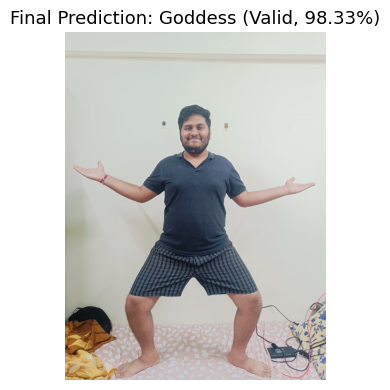

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Function to visualize results for multiple images
def display_results(image_paths, predictions):
    """Displays multiple images with their corresponding predictions side by side."""
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 4))

    if len(image_paths) == 1:  # If only one image, make axes iterable
        axes = [axes]

    for ax, (image_path, (final_pose, final_accuracy, pose_validity)) in zip(axes, zip(image_paths, predictions)):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Final Prediction: {final_pose} ({pose_validity}, {final_accuracy:.2f}%)", fontsize=13)

    plt.tight_layout()
    plt.show()

# List of test images
image_paths = [
    "/content/drive/My Drive/Testing/Goddess_Pose.jpg",
    # "/content/drive/My Drive/Testing/Tree_Pose_1.png",
    # "/content/drive/My Drive/Testing/Warrior_Pose_1.png",
    # "/content/drive/My Drive/Testing/Downdog_Pose.jpeg",
    # "/content/drive/My Drive/Testing/Plank_Pose.png"
]

# Get predictions for all images
predictions = [validate_pose(image_path) for image_path in image_paths]

# Display results
display_results(image_paths, predictions)
